In [1]:
import sys
print(sys.version)
print(*sys.path, sep='\n')

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload

/home/lukec/venv/lib/python3.6/site-packages
/home/lukec/Downloads/jax/build
/home/lukec/.local/lib/python3.6/site-packages
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/home/lukec/venv/lib/python3.6/site-packages/IPython/extensions
/home/lukec/.ipython


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
6


In [4]:
# parameters for trained CNN
ROOT = os.path.join('.', 'dataset_root')
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 15

In [5]:
def imshow(tensor_grid, mean=0., std=1., title=None):
    assert isinstance(tensor_grid, torch.Tensor)
    assert len(tensor_grid.size()) == 4, \
        f'For a batch of images only, {tensor_grid.size()} '
    
    tensor_grid = tv.utils.make_grid(tensor_grid)
    grid = tensor_grid.numpy().transpose((1,2,0))
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

In [6]:
# prepare data
# foolbox model expects raw numpy array as image
transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
#         tv.transforms.Normalize(mean, std)
])
train_dataset = tv.datasets.MNIST(
    ROOT,
    train=True, 
    download=True,
    transform=transform)
test_dataset = tv.datasets.MNIST(
    ROOT,
    train=False, 
    download=True,
    transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers
)

In [7]:
x = torch.rand(1, 1, 28, 28)
print(x.size())

conv = nn.Conv2d(1, 32, 3, 1)
x = conv(x)
print(x.size())
pool = nn.MaxPool2d(2)
x = pool(x)
print(x.size())
conv = nn.Conv2d(32, 64, 3, 2)
x = conv(x)
print(x.size())
pool = nn.MaxPool2d(2)
x = pool(x)
print(x.size())
conv = nn.Conv2d(64, 128, 3, 2)
x = conv(x)
print(x.size())

print('\nDecoding')
convt = nn.ConvTranspose2d(128, 64, 3, 2)
x = convt(x)
print(x.size())
convt = nn.ConvTranspose2d(64, 32, 3, 2)
x = convt(x)
print(x.size())
convt = nn.ConvTranspose2d(32, 32, 3, 2)
x = convt(x)
print(x.size())
up = nn.Upsample((26, 26), mode='bilinear', align_corners=True)
x = up(x)
print(x.size())
convt = nn.ConvTranspose2d(32, 1, 3, 1)
x = convt(x)
print(x.size())

torch.Size([1, 1, 28, 28])
torch.Size([1, 32, 26, 26])
torch.Size([1, 32, 13, 13])
torch.Size([1, 64, 6, 6])
torch.Size([1, 64, 3, 3])
torch.Size([1, 128, 1, 1])

Decoding
torch.Size([1, 64, 3, 3])
torch.Size([1, 32, 7, 7])
torch.Size([1, 32, 15, 15])
torch.Size([1, 32, 26, 26])
torch.Size([1, 1, 28, 28])


In [8]:
class Autoencoder(nn.Module):
    def __init__(self, batch_size=BATCH_SIZE):
        super(Autoencoder, self).__init__()
        self.batch_size = batch_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 2))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, 2),
            nn.ReLU(),
            nn.Upsample((26, 26), mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(32, 1, 3, 1),
            nn.Tanh())
                
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        assert isinstance(x, torch.Tensor) \
            and x.size() == (self.batch_size, 1, 28, 28)
        return self.encoder(x)
    
    def decode(self, x):
        assert isinstance(x, torch.Tensor) \
            and x.size() in ((self.batch_size, 128, 1, 1), (self.batch_size, 128))
        
        if x.size() == (self.batch_size, 128):
            x = x.view(self.batch_size, 128, 1, 1)
        
        return self.decoder(x)

In [9]:
autoencoder = Autoencoder(BATCH_SIZE)
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Upsample(size=(26, 26), mode=bilinear)
    (7): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
    (8): Tanh()
  )
)

torch.Size([64, 1, 28, 28])
torch.Size([64, 128, 1, 1])


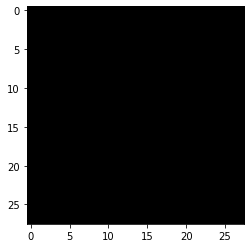

In [10]:
# sanity check
# x are noise images
x = torch.rand(BATCH_SIZE, 1, 28, 28)
print(x.size())
x = x.to(device)

output = autoencoder(x)
assert output.size() == x.size()

en = autoencoder.encode(x)
print(en.size())
assert en.size() == (BATCH_SIZE, 128, 1, 1)

de = autoencoder.decode(en)
assert de.size() == x.size()

# y are encoded images
y = torch.randn(BATCH_SIZE, 128)
y = y.to(device)
de = autoencoder.decode(y)
assert de.size() == x.size()

plt.figure()
imshow(output[:1].cpu().detach())
plt.show()

In [11]:
optimizer = torch.optim.Adam(
    autoencoder.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY)

In [12]:
def train(autoencoder, loader, optimizer, epochs=EPOCHS):
    autoencoder.train()
    
    for epoch in range(epochs):
        since = time.time()
        for x, y in loader:
            x = x.to(device)

            optimizer.zero_grad()
            outputs = autoencoder(x)
            loss = F.mse_loss(outputs, x)
            loss.backward()    
            optimizer.step()
        
        time_elapsed = time.time() - since
        print('Epoch: {:2d} - Time: {:.0f}m {:.1f}s - Loss: {:.4f}'.format(
            epoch + 1,
            time_elapsed // 60, time_elapsed % 60,
            loss.item()))

In [13]:
since = time.time()

train(autoencoder, train_loader, optimizer)

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))

Epoch:  1 - Time: 0m 4.1s - Loss: 0.0113
Epoch:  2 - Time: 0m 4.0s - Loss: 0.0064
Epoch:  3 - Time: 0m 3.9s - Loss: 0.0068
Epoch:  4 - Time: 0m 3.9s - Loss: 0.0054
Epoch:  5 - Time: 0m 4.0s - Loss: 0.0052
Epoch:  6 - Time: 0m 3.9s - Loss: 0.0051
Epoch:  7 - Time: 0m 4.0s - Loss: 0.0051
Epoch:  8 - Time: 0m 3.9s - Loss: 0.0045
Epoch:  9 - Time: 0m 3.8s - Loss: 0.0049
Epoch: 10 - Time: 0m 3.8s - Loss: 0.0053
Epoch: 11 - Time: 0m 3.9s - Loss: 0.0044
Epoch: 12 - Time: 0m 3.9s - Loss: 0.0042
Epoch: 13 - Time: 0m 3.9s - Loss: 0.0043
Epoch: 14 - Time: 0m 3.9s - Loss: 0.0038
Epoch: 15 - Time: 0m 3.9s - Loss: 0.0044
Training completed in 0m 58.8s


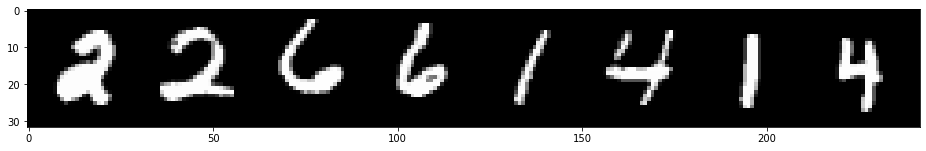

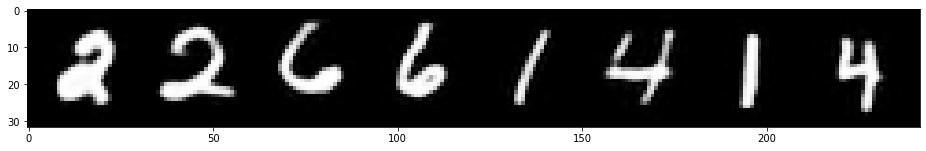

In [14]:
inputs = next(iter(test_loader))[0]
inputs = inputs[:8].to(device)
outpus = autoencoder(inputs)

plt.figure(figsize=[16, 8])
imshow(inputs.cpu().detach())
plt.show()

plt.figure(figsize=[16, 8])
imshow(outpus.cpu().detach())
plt.show()

In [15]:
torch.save(autoencoder.state_dict(), 'mnist_autoencoder.pt')